In [1]:
#import librarys

import requests
import pandas as pd
from datetime import timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def daterange(start_date, end_date):
    '''Function to create a list of dates between the inputted start and end date'''
    for n in range(int ((end_date - start_date).days)):
        current_day = start_date + timedelta(n)
        formatted_date = current_day.strftime('%m-%d-%Y')
        yield formatted_date

In [3]:
def request_data(start_date, end_date):
    '''Function that requests US data and concatenates it into a single dataframe'''
    df = pd.DataFrame()
    for single_date in daterange(start_date, end_date):
        date = single_date
        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/' + date + '.csv'
        raw_data = pd.read_csv(url, error_bad_lines=False)
        raw_data['Date'] = single_date
        df = pd.concat([df, raw_data])
    return df

# Define inputs
start_date = date(2020, 4, 12)
today = date.today()
one_day = timedelta(1)
end_date = today - one_day

#Run function
data = request_data(start_date, end_date)

In [4]:
 def clean_df(df):
    '''Function that cleans the dataframe of unwanted data, drops outliers, and defines indexes'''
    df = df.rename(columns={'Province_State': 'State'})
    df.set_index(['State','Date'], inplace=True)
    df.sort_index(inplace=True)
    # Remove irrelavent rows
    df.drop(index=['American Samoa','Diamond Princess','Recovered','Guam'], level=0, inplace=True)
    df = df[df.Country_Region == 'US']
    df.drop(['Country_Region','Last_Update', 'Lat', 'Long_', 'Recovered', 'Active', 'FIPS', 'Incident_Rate', 'People_Hospitalized', 'Mortality_Rate', 'UID', 'ISO3', 'Testing_Rate', 'Hospitalization_Rate'], axis=1, inplace=True)
    return df
    
data = clean_df(data)

In [5]:
def daily_confirmed(df):
    '''Function that adds the number of daily cases confirmed'''
    previous = 0
    for i, row in df.iterrows():
        df.loc[i, 'Daily_Confirmed'] = row['Confirmed'] - previous
        previous = row['Confirmed']
    return df   

data = daily_confirmed(data)

In [6]:
def avg_daily_confirmed(df):
    '''Function that adds the average of daily cases confirmed over a fixed period of time'''
    df['Avg_Daily_Confirmed'] = df['Daily_Confirmed'].rolling(window=5).mean()
    return df

data = avg_daily_confirmed(data)

In [7]:
def change_avg_daily_confirmed(df):
    '''Function that adds the change of the daily confirmed cases'''
    previous = 0
    for i, row in df.iterrows():
        if previous == 0:
            pass
        else:
            df.loc[i,'Change_Avg_Daily_Confirmed'] = ((row['Avg_Daily_Confirmed'] - previous ) / previous) * 100
        previous = row['Avg_Daily_Confirmed']
    return df

data = change_avg_daily_confirmed(data)

In [8]:
def daily_tests(df):
    '''Function that adds the number of daily tests'''
    previous = 0
    for i, row in df.iterrows():
        df.loc[i, 'Daily_Tests'] = row['People_Tested'] - previous
        previous = row['People_Tested']
    return df   

data = daily_tests(data)

In [9]:
def daily_tests_positive(df):
    '''Function that adds the number of daily positive tests'''
    for i, row in df.iterrows():
        if row['Daily_Tests'] == 0:
            pass
        else:
            df.loc[i, 'Daily_Tests_Positive'] = row['Daily_Confirmed'] / row['Daily_Tests'] * 100
    return df   

data = daily_tests_positive(data)

In [10]:
# Determine 14 day average of perecent positive tests
def avg_daily_tests_positive(df):
    '''Function that adds the average number of positive tests over a fixed period of time'''
    df['Avg_Daily_Tests_Positive'] = df['Daily_Tests_Positive'].rolling(window=5).mean()
    return df

data = avg_daily_tests_positive(data)

In [11]:
def change_avg_daily_tests_positive(df):
    '''Function that adds the change of the daily positive test percentage'''
    previous = 0
    for i, row in df.iterrows():
        if previous == 0:
            pass
        else:
            df.loc[i,'Change_Avg_Daily_Tests_Positive'] = ((row['Avg_Daily_Tests_Positive'] - previous ) / previous) * 100
        previous = row['Avg_Daily_Tests_Positive']
    return df

data = change_avg_daily_tests_positive(data)

In [12]:
def generate_excel_output(df):
    '''Function that organizes the dataframe and exports the data to 'output' file'''
    df = df[['Confirmed', 'Daily_Confirmed', 'Avg_Daily_Confirmed', 'Change_Avg_Daily_Confirmed', 'Daily_Tests', 'Daily_Tests_Positive', 'Avg_Daily_Tests_Positive', 'Change_Avg_Daily_Tests_Positive','Deaths']]
    df.to_excel('output.xlsx')

generate_excel_output(data)

Date
04-12-2020    37330.8
04-13-2020    38645.6
04-14-2020    40072.0
04-15-2020    42345.6
04-16-2020    44173.2
04-17-2020     8312.8
04-18-2020     9192.6
04-19-2020     8959.0
04-20-2020     7721.2
04-21-2020     6934.0
04-22-2020     6539.0
04-23-2020     4349.6
04-24-2020     4755.0
04-25-2020     5816.6
04-26-2020     5936.8
04-27-2020     5740.8
Name: Avg_Daily_Confirmed, dtype: float64


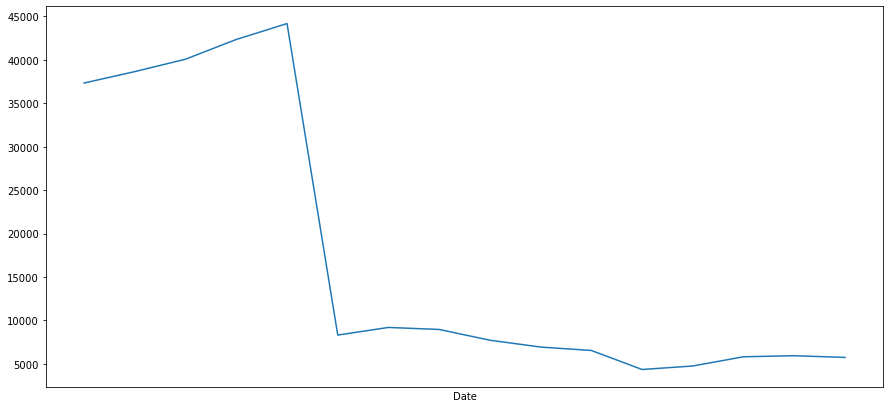

In [13]:
def line_plot_data_type(df, column, state = ' '):
    '''Function that requests df, attribute, and state to be plotted on a line graph'''
    #plot data
    df = df.loc[state, column]
    print(df)
    fig, ax = plt.subplots(figsize=(15,7))
    df.plot(ax=ax)

    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    
line_plot_data_type(data, 'Avg_Daily_Confirmed', 'New York')